In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcsetup.all_backends
import pickle

import pyExSi

import LadiskDAQ

%matplotlib notebook

<IPython.core.display.Javascript object>


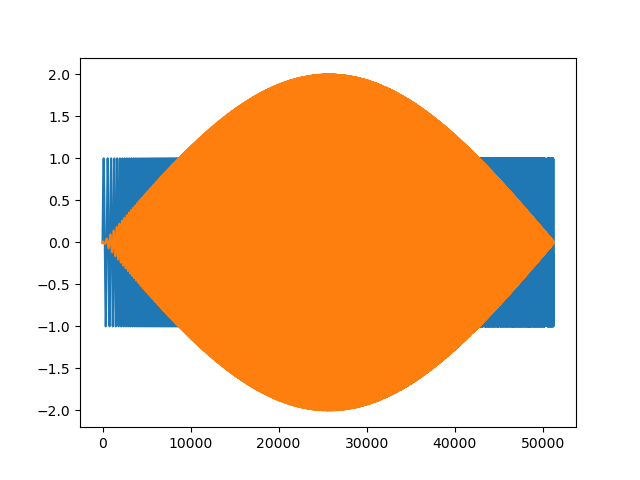

In [2]:
#create signal:

fs = 51200 # output sample rate
time_array = np.arange(fs) / fs  

signal1 = pyExSi.sine_sweep(time_array, freq_start=100, freq_stop=2000)
#signal2 = 0.1*np.sin(time_array*2*np.pi*50-0.4*np.pi) + 0.01*np.cos(time_array*2*np.pi*100-np.pi)
#signal2 = np.sin(time_array*2*np.pi*500)

arr = np.linspace(0, np.pi, len(signal1))
amp2 = np.sin( arr )
signal2 = - signal1 * amp2

signal2 = np.roll(signal2, 100) * 2

signal = np.array([signal1, signal2])
signal.shape

plt.plot(signal.T)

In [3]:
# signal generation object:
gen = LadiskDAQ.NIGenerator('TestOutputTask', signal)
# signal acquisition object
acq = LadiskDAQ.NIAcquisition('TestInputTask')
acq.set_trigger(0.4, 0, duration=4) #TODO

In [4]:
# configure plot:
plot_layout={
    (0, 0): [1, 0],
    (0, 1): [1, 0, "fft", "logy"],
    (1, 0): [(0, 1), "frf_amp"],
    (1, 1): [(0, 1), "frf_phase"],
}

# create DAQ object:
ldaq = LadiskDAQ.LDAQ(acq, gen)
ldaq.configure(plot_layout=plot_layout, max_time=1., autoclose=True, nth_point=1)

In [5]:
ldaq.run()

Press "q" to stop measurement.
	Waiting for trigger...triggered.
	Recording...stop.


In [19]:
root = r'C:\LADISK\packages\LadiskDAQ'
filename = "test2"
ldaq.save_measurement(filename,root, timestamp=False, comment="testetsstas")

In [20]:
meas = LadiskDAQ.load_measurement(filename+".pkl", root)
meas

{'data': array([[-0.0043492 ,  0.00220896],
        [-0.0043492 ,  0.0012609 ],
        [-0.00403053,  0.00220896],
        ...,
        [-0.15380261,  0.12198016],
        [-0.187581  ,  0.1210321 ],
        [-0.22072205,  0.12134812]]),
 'channel_names': ['Voltage', 'Voltage_0'],
 'comment': 'testetsstas',
 'sample_rate': 25600.0}